# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je do 8. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 14. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
# datová analytika
import pandas as pd
import numpy as np

# grafy
import matplotlib.pyplot as plt

# modely
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# vyhodnocování a předzpracování
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

# redukce dimenzionality
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

import random

# Příprava dat

### Načtení dat

In [2]:
df = pd.read_csv("train.csv")

### Rozdělení do podmnožin

In [3]:
TRAIN_SIZE = 0.7 # velikost trénovací množiny
VALID_PROPORTION = 0.5 # poměr velikosti validační množiny vůči testovací
RANDOM_SEED = 666

In [4]:
# Rozdělení datasetu na vysvětlovaný příznak a zbylá data
X = df.drop("label", axis=1)
y = df["label"]

In [5]:
# Rozdělení datasetu na trénovací, validační a testovací množiny
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)
X_Valid, X_Test, y_Valid, y_Test = train_test_split(X_Test, y_Test, train_size=VALID_PROPORTION, random_state=RANDOM_SEED)

print(f"Počet dat v trénovací množině: {X_Test.shape[0]} ({int(TRAIN_SIZE * 100)} %)")
print(f"Počet dat v validační množině: {X_Test.shape[0]} ({int((1 - TRAIN_SIZE) * VALID_PROPORTION * 100)} %)")
print(f"Počet dat v testovací množině: {X_Test.shape[0]} ({int((1 - TRAIN_SIZE) * VALID_PROPORTION * 100)} %)")

Počet dat v trénovací množině: 360 (70 %)
Počet dat v validační množině: 360 (15 %)
Počet dat v testovací množině: 360 (15 %)


# Průzkum dat

In [6]:
print("Rozměry datasetu:", df.shape)

Rozměry datasetu: (2400, 785)


Dataset obsahuje `784` sloupců s hodnotou v rozmezí 0-255 příslušejícího **pixelu** a `1` sloupec s binární proměnnou **label**.

Ve výpisu si můžeme všimnout, že se v datech **statistické míry** mezi pixeli **výrazně liší**.

Například sloupec **pixel3** má `průměrnou hodnotu` 0.06 a `maximální hodnotu` 30, zato sloupec **pixel775** má `průměrnou hodnotu` 78.5 a `maximální hodnotu` 248.

In [7]:
print("Názvy sloupců nezačínající slovem pixel:\n", [i for i in df.columns if not i.startswith("pixel")])
df.describe()

Názvy sloupců nezačínající slovem pixel:
 ['label']


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.500417,0.000417,0.002917,0.066667,0.144583,0.216667,0.462917,1.605833,4.184167,10.954167,...,78.508750,49.705417,34.747083,14.742500,3.866667,1.334167,0.341250,0.141250,0.036250,0.006667
std,0.500104,0.020412,0.053939,0.688539,2.762431,2.343682,4.989054,12.574764,21.183025,33.693930,...,66.539823,62.185924,56.259061,37.883132,18.662614,10.515159,4.338699,3.205685,0.930661,0.287211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,74.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,129.000000,92.250000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,30.000000,132.000000,85.000000,172.000000,189.000000,255.000000,227.000000,...,248.000000,247.000000,241.000000,244.000000,215.000000,184.000000,116.000000,106.000000,31.000000,14.000000


In [8]:
print("Unikátní hodnoty ve sloupci label:\n", set(i for i in df["label"]))

Unikátní hodnoty ve sloupci label:
 {0, 1}


In [9]:
res = set()
for col in df.columns:
    for j in df[col]:
        res.add(j)

print("Sloupce s pixely obsahují všechny hodnoty mezi 0 a 255:", res == set(i for i in range(0, 256)))

Sloupce s pixely obsahují všechny hodnoty mezi 0 a 255: True


Po zobrazení několika datových bodů odhadujeme, že se v datasetu nacházejí obrázky **triček** a **kalhot**, kde jsou pixely ve **stupních šedi**. 

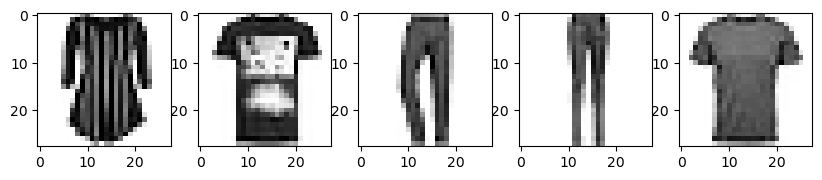

In [10]:
# přeměna datových bodů na 2D pole velikosti 28x28
images = df.drop("label", axis=1).values.reshape((len(df["label"]), 28, 28))

# vytvoření figure s 5 sloupci
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))

for i in range(5):
    rand_pos = random.randrange(0, len(images)) # vygenerování náhodné hodnoty
    axes[i].imshow(images[rand_pos], cmap='Greys') # zobrazení datového bodu

# Klasifikace dat

Příprava **standardizovaných** a **normalizovaných** dat

In [11]:
# Standardizace
scaler = StandardScaler().fit(X_Train)

X_Train_standard = scaler.transform(X_Train)
X_Valid_standard = scaler.transform(X_Valid)
X_Test_standard = scaler.transform(X_Test)

# Normalizace
normalizer = Normalizer().fit(X_Train)

X_Train_normalized = normalizer.transform(X_Train)
X_Valid_normalized = normalizer.transform(X_Valid)
X_Test_normalized = normalizer.transform(X_Test)


_Nejdříve se pokusíme natrénovat modely **bez** redukce dimenzionality._

### SVM

Tato metoda je obecně **efektivní** na datech s **vysokou dimenzí** a proto by mohl být tento model **vhodný** pro naší aplikaci.

Důležitým faktorem bude, jestli **existuje** nějaká **nadrovina**, která data dokáže **separovat**.

In [12]:
threshold = 0.95 # akceptovatelný podíl špatně klasifikovaných bodů
C = 1 / (threshold * len(y_Train)) # standardní zvolení penalizačního členu

Nejprve zvolíme pro `SVM` model **lineární jádro**.

In [13]:
# trénování
clf_SVM_lin = SVC(C = C, kernel = 'linear')
clf_SVM_lin.fit(X_Train, y_Train)

# predikce
pred_train_svm_lin = clf_SVM_lin.predict(X_Train)
pred_valid_svm_lin = clf_SVM_lin.predict(X_Valid)

**Přesnost** takto natrénovaného modelu na testovacích datech je **více než 99%**.

`SVM` model s **lineárním jádrem** využil jako **podpůrné vektory** pouze **6,9% bodů** trénovací množiny.

In [14]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_lin):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_lin):.3f}\n")

# uložení přesnosti na validační množině pro lazení dimenze
acc_valid_svm_lin = accuracy_score(y_Valid, pred_valid_svm_lin)

# parametry modelu
n_supp = clf_SVM_lin.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_lin.intercept_}")

Přesnost modelu na trénovací množině: 1.000
Přesnost modelu na validační množině: 0.992

Počet podpůrných vektorů 116 tvoří 6.9 % trénovací množiny.
Intercept = [-0.94942133]


Nyní zkusíme použít `SVM` s **lineárním jádrem** na **standardizovaná** data.

In [15]:
clf_SVM_lin = SVC(C = C, kernel = 'linear')
clf_SVM_lin.fit(X_Train_standard, y_Train)

# predikce
pred_train_svm_lin = clf_SVM_lin.predict(X_Train_standard)
pred_valid_svm_lin = clf_SVM_lin.predict(X_Valid_standard)

Po standardizace dat je **přesnost** opět vělmi vysoká **~99%**.

In [16]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_lin):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_lin):.3f}\n")

# parametry modelu
n_supp = clf_SVM_lin.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train_standard.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_lin.intercept_}")

Přesnost modelu na trénovací množině: 0.989
Přesnost modelu na validační množině: 0.986

Počet podpůrných vektorů 218 tvoří 13.0 % trénovací množiny.
Intercept = [0.09519151]


Nyní zkusíme použít `SVM` s **lineárním jádrem** na **normalizovaná** data.

In [17]:
clf_SVM_lin = SVC(C = C, kernel = 'linear')
clf_SVM_lin.fit(X_Train_normalized, y_Train)

# predikce
pred_train_svm_lin = clf_SVM_lin.predict(X_Train_normalized)
pred_valid_svm_lin = clf_SVM_lin.predict(X_Valid_normalized)

Po normalizaci **klesla přesnost** na **~50%** a jako **podpůrné vektory** vybrala metoda **téměř celý dataset** (~99,5%).

In [18]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_lin):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_lin):.3f}\n")

# parametry modelu
n_supp = clf_SVM_lin.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train_normalized.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_lin.intercept_}")

Přesnost modelu na trénovací množině: 0.502
Přesnost modelu na validační množině: 0.517

Počet podpůrných vektorů 1672 tvoří 99.5 % trénovací množiny.
Intercept = [0.88712291]


Další variantou jádra `SVM` modelu je **gaussovské jádro**.

In [19]:
# trénování
clf_SVM_rbf = SVC(C = C, kernel = 'rbf', gamma = 'scale')
clf_SVM_rbf.fit(X_Train, y_Train)

# uložení přesnosti na validační množině pro lazení dimenze
acc_valid_svm_rbf = accuracy_score(y_Valid, pred_valid_svm_lin)

# predikce
pred_train_svm_rbf = clf_SVM_rbf.predict(X_Train)
pred_valid_svm_rbf = clf_SVM_rbf.predict(X_Valid)

Přesnost `SVM` modelu s **gaussovským jádrem** je na všech množinách pouze **~50%**.

Jako **podpůrné vektory** se použilo **99.5%** trénovací množiny.

In [20]:
# měření přesnosti
print(f"Odhad přesnosti modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_rbf):.3f}")
print(f"Odhad přesnosti modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_rbf):.3f}\n")

# parametry modelu
n_supp = clf_SVM_rbf.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_rbf.intercept_}")

Odhad přesnosti modelu na trénovací množině: 0.502
Odhad přesnosti modelu na validační množině: 0.517

Počet podpůrných vektorů 1672 tvoří 99.5 % trénovací množiny.
Intercept = [0.80396807]


Nyní zkusíme použít `SVM` s **gaussovským jádrem** na **standardizovaná** data.

In [21]:
clf_SVM_lin = SVC(C = C, kernel = 'rbf', gamma = 'scale')
clf_SVM_lin.fit(X_Train_standard, y_Train)

# predikce
pred_train_svm_lin = clf_SVM_lin.predict(X_Train_standard)
pred_valid_svm_lin = clf_SVM_lin.predict(X_Valid_standard)

Po standardizace dat se **přesnost** (~50%) ani počet **podpůrných vektorů** **nezměnil**.

Změnil se jenom _intercept_.

In [22]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_lin):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_lin):.3f}\n")

# parametry modelu
n_supp = clf_SVM_lin.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train_standard.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_lin.intercept_}")

Přesnost modelu na trénovací množině: 0.502
Přesnost modelu na validační množině: 0.517

Počet podpůrných vektorů 1672 tvoří 99.5 % trénovací množiny.
Intercept = [0.79319035]


Nyní zkusíme použít `SVM` s **gaussovským jádrem** na **normalizovaná** data.

In [23]:
clf_SVM_lin = SVC(C = C, kernel = 'rbf', gamma = 'scale')
clf_SVM_lin.fit(X_Train_normalized, y_Train)

# predikce
pred_train_svm_lin = clf_SVM_lin.predict(X_Train_normalized)
pred_valid_svm_lin = clf_SVM_lin.predict(X_Valid_normalized)

Po normalizaci se **přesnost** modelu ani počet **podpůrných věktorů nezměnil**.

Opět se změnil pouze _intercept_.

In [24]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_svm_lin):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_svm_lin):.3f}")

# parametry modelu
n_supp = clf_SVM_lin.support_.shape[0]
print(f"Počet podpůrných vektorů {n_supp} tvoří {100*n_supp/X_Train_normalized.shape[0]:.1f} % trénovací množiny.")
print(f"Intercept = {clf_SVM_lin.intercept_}")

Přesnost modelu na trénovací množině: 0.502
Přesnost modelu na validační množině: 0.517
Počet podpůrných vektorů 1672 tvoří 99.5 % trénovací množiny.
Intercept = [0.81820631]


### naivní Bayesův klasifikátor

Tento model předpokládá **nezávislost příznaků** mezi sebou a při **vysoké dimenzi** dat jako v našem případě by mohl **minimalizovat problémy s přetrénováním**.

Vhodným modelem pro diskrétní příznaky je **kategorické rozdělení**.

In [25]:
# trénování
clf_multi = MultinomialNB()
clf_multi.fit(X_Train, y_Train)

# predikce
pred_train_multi = clf_multi.predict(X_Train)
pred_valid_multi = clf_multi.predict(X_Valid)

**Přesnost** modelu je **~95%** na všech množinách.

Počet vzorků každé třídy je v datasetu téměř stejný, a proto je i **odhad pravděpodobnosti tříd ~50%**.

In [26]:
# měření přesnosti
print(f"Odhad přesnosti modelu na trénovací množině: {accuracy_score(y_Train, pred_train_multi):.3f}")
print(f"Odhad přesnosti modelu na validační množině: {accuracy_score(y_Valid, pred_valid_multi):.3f}\n")

# uložení přesnosti na validační množině pro lazení dimenze
acc_valid_multi = accuracy_score(y_Valid, pred_valid_multi)

# parametry modelu
print('Třídy vysvětlované proměnné:', clf_multi.classes_)
print('Počty vzorků pro každou třídu:', clf_multi.class_count_)
print(f"Odhady pravděpodobnosti jednotlivých tříd: {np.exp(clf_multi.class_log_prior_)}")

Odhad přesnosti modelu na trénovací množině: 0.952
Odhad přesnosti modelu na validační množině: 0.944

Třídy vysvětlované proměnné: [0 1]
Počty vzorků pro každou třídu: [836. 844.]
Odhady pravděpodobnosti jednotlivých tříd: [0.49761905 0.50238095]


Následně vyzkoušíme **standardizovat** data a model znovu natrénovat.

*Poznámka:* Abychom mohli použít model `MultinomialNB`, standardizaci provedeme **bez centrování** podle průměru (parametr *with_mean*).

In [27]:
# nastavení standardizace
scaler = StandardScaler(with_mean=False).fit(X_Train)

In [28]:
clf_multi = MultinomialNB()
clf_multi.fit(scaler.transform(X_Train), y_Train)

# predikce
pred_train_multi = clf_multi.predict(scaler.transform(X_Train))
pred_valid_multi = clf_multi.predict(scaler.transform(X_Valid))

**Přesnost** se po standardizaci téměř **nezměnila** a zůstala ~95% na všech množinách.

In [29]:
# měření přesnosti
print(f"Odhad přesnosti modelu na trénovací množině: {accuracy_score(y_Train, pred_train_multi):.3f}")
print(f"Odhad přesnosti modelu na validační množině: {accuracy_score(y_Valid, pred_valid_multi):.3f}\n")

# parametry modelu
print('Třídy vysvětlované proměnné:', clf_multi.classes_)
print('Počty vzorků pro každou třídu:', clf_multi.class_count_)
print(f"Odhady pravděpodobnosti jednotlivých tříd: {np.exp(clf_multi.class_log_prior_)}")

Odhad přesnosti modelu na trénovací množině: 0.947
Odhad přesnosti modelu na validační množině: 0.942

Třídy vysvětlované proměnné: [0 1]
Počty vzorků pro každou třídu: [836. 844.]
Odhady pravděpodobnosti jednotlivých tříd: [0.49761905 0.50238095]


Dále zkusíme model použít na **normalizovaných** datech. 

In [30]:
# trénování
clf_multi = MultinomialNB()
clf_multi.fit(X_Train_normalized, y_Train)

# predikce
pred_train_multi = clf_multi.predict(X_Train_normalized)
pred_valid_multi = clf_multi.predict(X_Valid_normalized)

Ani po normalizaci se **přesnost** predikce téměř **nezměnila** a zůstala ~95%.

In [31]:
# měření přesnosti
print(f"Odhad přesnosti modelu na trénovací množině: {accuracy_score(y_Train, pred_train_multi):.3f}")
print(f"Odhad přesnosti modelu na validační množině: {accuracy_score(y_Valid, pred_valid_multi):.3f}\n")

# parametry modelu
print('Třídy vysvětlované proměnné:', clf_multi.classes_)
print('Počty vzorků pro každou třídu:', clf_multi.class_count_)
print(f"Odhady pravděpodobnosti jednotlivých tříd: {np.exp(clf_multi.class_log_prior_)}")

Odhad přesnosti modelu na trénovací množině: 0.951
Odhad přesnosti modelu na validační množině: 0.942

Třídy vysvětlované proměnné: [0 1]
Počty vzorků pro každou třídu: [836. 844.]
Odhady pravděpodobnosti jednotlivých tříd: [0.49761905 0.50238095]


_Parametry modelu se po standardizaci ani normalizaci nezměnili._

### LDA

Tento model je **vhodný** na problémy **klasifikace** na datech s **vysokou dimenzí** jako jsou naše.

Pokud tedy **nedojde** k **přetrénování** kvůli vysoké dimenzi, měl by model fungovat na našich datech **dobře**.

Dalším modelem, který budeme trénovat, je `lineární diskriminační analýza`.

In [32]:
# trénování
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_Train, y_Train)

# predikce
pred_train_LDA = clf_LDA.predict(X_Train)
pred_valid_LDA = clf_LDA.predict(X_Valid)

Na **trénovací** množině je **přesnost** této metody **100%**, na **testovací** množině je **~93%**.

In [33]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_LDA):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_LDA):.3f}")

# uložení přesnosti na validační množině pro lazení dimenze
acc_valid_lda = accuracy_score(y_Valid, pred_valid_LDA)

Přesnost modelu na trénovací množině: 0.999
Přesnost modelu na validační množině: 0.939


Model nyní vyzkoušíme na **standardizovaných** datech.

In [34]:
# trénování
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_Train_standard, y_Train)

# predikce
pred_train_LDA = clf_LDA.predict(X_Train_standard)
pred_valid_LDA = clf_LDA.predict(X_Valid_standard)

**Přesnost** modelu se na množinách vůbec **nezměnila** (100% na trénovací a 93% na testovací).

In [35]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_LDA):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_LDA):.3f}")

Přesnost modelu na trénovací množině: 0.999
Přesnost modelu na validační množině: 0.939


Následně model vyzkoušíme na **normalizovaných datech**.

In [36]:
# trénování
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_Train_normalized, y_Train)

# predikce
pred_train_LDA = clf_LDA.predict(X_Train_normalized)
pred_valid_LDA = clf_LDA.predict(X_Valid_normalized)

Po normalizaci dat se **přesnost** mírně zvýšila u testovací množiny, jinak **zůstala podobná**. 

In [37]:
# měření přesnosti
print(f"Přesnost modelu na trénovací množině: {accuracy_score(y_Train, pred_train_LDA):.3f}")
print(f"Přesnost modelu na validační množině: {accuracy_score(y_Valid, pred_valid_LDA):.3f}")

Přesnost modelu na trénovací množině: 0.999
Přesnost modelu na validační množině: 0.936


## Aplikace PCA

_Nejdříve si připravíme funkci na vykreslení vývoje přesnosti modelu při měnění dimenze._

In [38]:
def plot_acc_development(accuracies_train:list, accuracies_valid:list, dimensions:list, full_acc:float, n_neighbors:int = None):
    plt.subplots(1, 1, figsize = (10, 5))
    if n_neighbors == None:
        plt.title("Vývoj přesnosti modelu při změně dimenze")
    else:
        plt.title(f"Vývoj přesnosti modelu při změně dimenze pro {n_neighbors} sousedů")
    plt.xlabel('Počet dimenzí')
    plt.ylabel('Přesnost modelu na testovacích datech')
    plt.xticks([dim for i, dim in enumerate(dimensions) if i % (max(1, len(dimensions) // 15)) == 0])
 
    plt.scatter(dimensions, accuracies_train, c='blue', label="Trénovací")
    plt.scatter(dimensions, accuracies_valid, c='red', label="Validační")
    plt.plot([0, max(dimensions)], [full_acc, full_acc],'g-', label="Nejvyšší přesnost bez redukce dimenze")
    plt.plot([0, max(dimensions)], [max(accuracies_train), max(accuracies_train)],'b--', label="Nejvyšší přesnost na trénovací množině")
    plt.plot([0, max(dimensions)], [max(accuracies_valid), max(accuracies_valid)],'r--', label="Nejvyšší přesnost na validační množině")
    plt.scatter(dimensions[np.argmax(accuracies_train)], max(accuracies_train), edgecolors="blue", marker = "o", facecolors = 'none', s = 250)
    plt.scatter(dimensions[np.argmax(accuracies_valid)], max(accuracies_valid), edgecolors="red", marker = "o", facecolors = 'none', s = 250)

    plt.legend()
    plt.show()

# funkce na výpis dimenzí, při kterých model dosahuje lepších přesností než bez redukce dimenzionality
def print_best_dims(best_dimensions:dict):
    print("DIMENZE, PŘESNOST")
    items = sorted(best_dimensions.items(), key = lambda x: x[1], reverse = True)
    for dim, acc in items[:10]:
        print(f"{dim}: {acc:.3f}")
    best_dimensions.clear()

_Parametry pro ladění dimenze metodou PCA._

Budeme zkoušet dimenze 10 až 770 se skoky po 10.

In [39]:
MIN_DIM = 10
MAX_DIM = len(X_Train.columns) - 10
STEP_SIZE = 10
DIMENSIONS = [i for i in range(MIN_DIM, MAX_DIM, STEP_SIZE)]

ACCs_train = np.zeros(len(DIMENSIONS)) # pole pro ukládání přesnosti na trénovací množině
ACCs_valid = np.zeros(len(DIMENSIONS)) # pole pro ukládání přesnosti na validační množině
BEST_DIMENSIONS = dict() # ukládání nejlepších výsledků

_Nyní budeme trénovat modely pro různé dimenze zredukované metodou PCA._

### SVM

Pro model `SVM` začneme opět s **lineárním jádrem**.

In [40]:
for i, dim in enumerate(DIMENSIONS):
    # PCA
    pca = PCA(n_components = dim)
    pca.fit(X_Train)

    # transformace dat do dim dimenzí
    X_Train_PCA = pca.transform(X_Train) 
    X_Valid_PCA = pca.transform(X_Valid) 

    # trénování
    clf_SVM_lin = SVC(C = C, kernel = 'linear')
    clf_SVM_lin.fit(X_Train_PCA, y_Train)

    # vyhodnocení
    pred_train = clf_SVM_lin.predict(X_Train_PCA)
    pred_valid = clf_SVM_lin.predict(X_Valid_PCA)
    ACCs_train[i] = accuracy_score(y_Train, pred_train) # trénovací množina
    ACCs_valid[i] = accuracy_score(y_Valid, pred_valid) # validační množina
    if ACCs_valid[i] > acc_valid_svm_lin:
        BEST_DIMENSIONS[dim] = ACCs_valid[i] # dobrý výsledek

Na grafu si můžeme všimnout, že **v dimezi ~250 a vyšší** stagnuje přesnost na validační množině na **stejné hodnotě** přesnosti jako při trénování **bez redukce** dimenzionality.

Přesnost na trénovací množině stagnuje již od dimenze ~90.

**Přesnosti vyšší než při trénování bez redukce dimenzionality jsme dosáhli v dimenzi 40.**

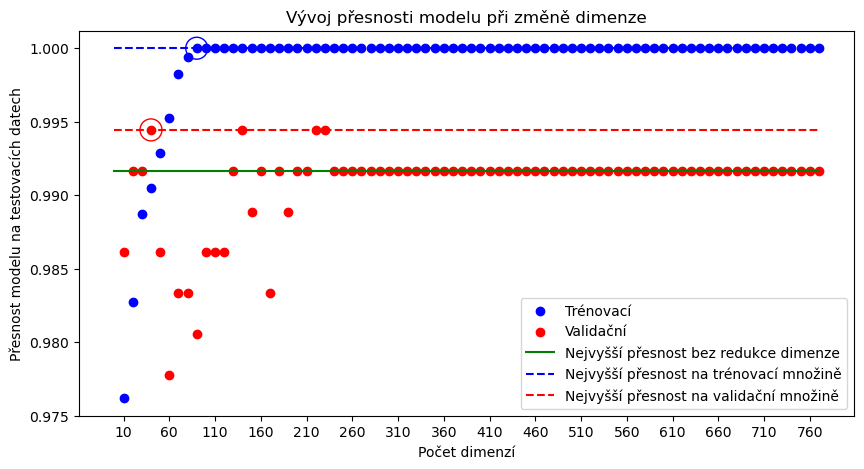

DIMENZE, PŘESNOST
40: 0.994
140: 0.994
220: 0.994
230: 0.994


In [41]:
plot_acc_development(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_svm_lin)
print_best_dims(BEST_DIMENSIONS)

_Nejlepšího výsledku modelu SVM s lineárním jádrem dosahujeme při dimenzi 40 a to přesnosti na validační množině 99.7%._

Nyní zkusíme `SVM` model s **gaussovským jádrem**.

In [42]:
for i, dim in enumerate(DIMENSIONS):
    # PCA
    pca = PCA(n_components = dim)
    pca.fit(X_Train)

    # transformace dat do dim dimenzí
    X_Train_PCA = pca.transform(X_Train) 
    X_Valid_PCA = pca.transform(X_Valid) 

    # trénování
    clf_SVM_rbf = SVC(C = C, kernel = 'rbf', gamma = 'scale')
    clf_SVM_rbf.fit(X_Train_PCA, y_Train)

    # vyhodnocení
    pred_train = clf_SVM_rbf.predict(X_Train_PCA)
    pred_valid = clf_SVM_rbf.predict(X_Valid_PCA)
    ACCs_train[i] = accuracy_score(y_Train, pred_train) # trénovací množina
    ACCs_valid[i] = accuracy_score(y_Valid, pred_valid) # validační množina
    if ACCs_valid[i] > acc_valid_svm_rbf:
        BEST_DIMENSIONS[dim] = ACCs_valid[i] # dobrý výsledek

Z grafu vidíme, že jsme po redukci dimenze dosáhli **stejného** výsledku, jako **bez redukce** dimenzionality. 

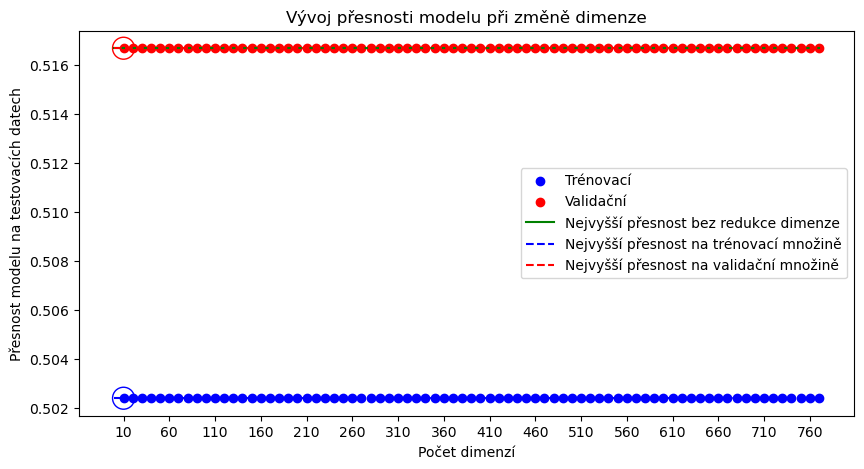

DIMENZE, PŘESNOST


In [43]:
plot_acc_development(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_svm_rbf)
print_best_dims(BEST_DIMENSIONS)

_Výsledek je v porovnání s ostatními modely výrazně slabší a proto není kandidát na finální model._

### naivní Bayesův klasifikátor

Nyní spustíme trénování `naivního Bayesova klasifikátoru`.

Po redukci dimenzionality **posuneme** hodnoty ve zredukovaném datasetu na **kladné hodnoty**, které vyžaduje model `MultinomialNB`.

In [44]:
for i, dim in enumerate(DIMENSIONS):
    # PCA
    pca = PCA(n_components = dim)
    pca.fit(X_Train)

    # transformace dat do dim dimenzí
    X_Train_PCA = pca.transform(X_Train) 
    X_Valid_PCA = pca.transform(X_Valid) 

    # transformace datasetu na kladná čísla
    X_Train_PCA -= np.min(X_Train_PCA)
    X_Valid_PCA -= np.min(X_Valid_PCA)
    
    # trénování
    clf_multi = MultinomialNB()
    clf_multi.fit(X_Train_PCA, y_Train)

    # vyhodnocení
    ACCs_train[i] = accuracy_score(y_Train, clf_multi.predict(X_Train_PCA)) # trénovací množina
    ACCs_valid[i] = accuracy_score(y_Valid, clf_multi.predict(X_Valid_PCA)) # validační množina
    if ACCs_valid[i] > acc_valid_multi:
        BEST_DIMENSIONS[dim] = ACCs_valid[i] # dobrý výsledek


Na výsledcích pozorujeme, že **nedosahujeme** tak dobrého výsledku, jako bez redukce dimenzionality.

Příčinou bude pravděpodobně **posun hodnot** na kladné hodnoty.

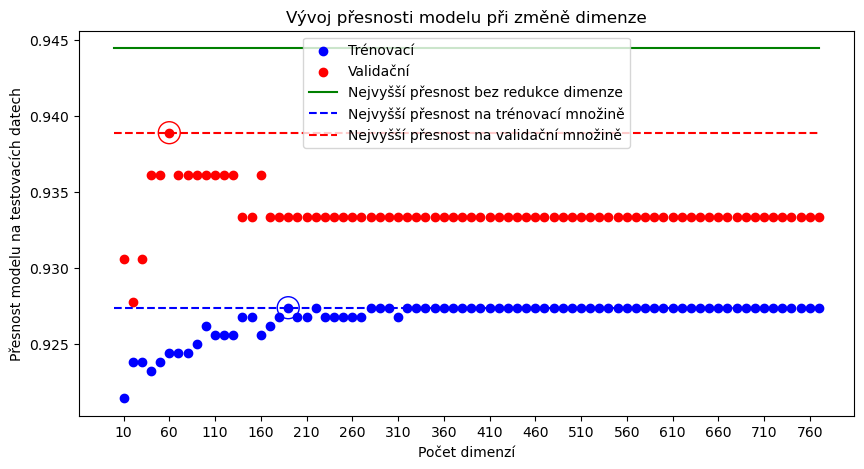

DIMENZE, PŘESNOST


In [45]:
plot_acc_development(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_multi)
print_best_dims(BEST_DIMENSIONS)

_Nejlepšího výsledku tedy dosahuje naivní Bayesův klasifikátor na datech v původním rozměru a to přesnosti 94.4% na validační množině._

### LDA

Dále vyzkoušíme trénování modelu `LDA` na datasetu s redukovanou dimenzí.

In [46]:
for i, dim in enumerate(DIMENSIONS):
    # PCA
    pca = PCA(n_components = dim)
    pca.fit(X_Train)

    # transformace dat do dim dimenzí
    X_Train_PCA = pca.transform(X_Train) 
    X_Valid_PCA = pca.transform(X_Valid)

    # trénování
    clf_LDA = LinearDiscriminantAnalysis()
    clf_LDA.fit(X_Train_PCA, y_Train)

    # vyhodnocení
    ACCs_train[i] = accuracy_score(y_Train, clf_LDA.predict(X_Train_PCA)) # trénovací množina
    ACCs_valid[i] = accuracy_score(y_Valid, clf_LDA.predict(X_Valid_PCA)) # validační množina
    if ACCs_valid[i] > acc_valid_lda:
        BEST_DIMENSIONS[dim] = ACCs_valid[i]

Výsledky se **výrazně zlepšili** oproti modelu natrénovanému na datech bez redukce dimenzionality.

Na vývoji přesnosti modelu pozorujeme **různý** trend pro trénovací a validační množinu. Tam kde se oba tyto trendy **protínají** je dimenze **~180** a **přesnost na validační množině ~98.9%**.

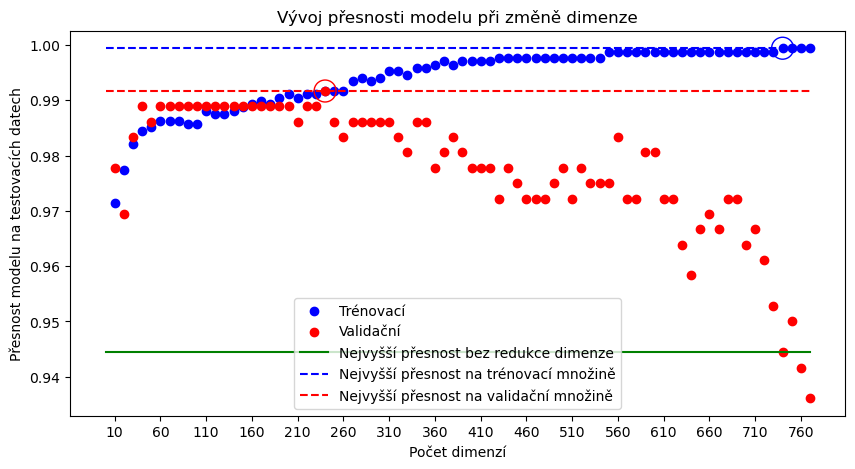

DIMENZE, PŘESNOST
240: 0.992
40: 0.989
60: 0.989
70: 0.989
80: 0.989
90: 0.989
100: 0.989
110: 0.989
120: 0.989
130: 0.989


In [47]:
plot_acc_development(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_multi)
print_best_dims(BEST_DIMENSIONS)

_Nejlepšího výsledků tedy dosahuje model LDA při dimenzi 180 a to přesnosti na validační množině 98.9%_

## Aplikace LLE

_Na vykreslení vývoje chyby měření při vývoji dimenze u LLE upravíme vykreslovací funkci._

In [48]:
def plot_acc_development_LLE(accuracies_train:list, accuracies_valid:list, dimensions:list, full_acc:float, n_neighbors:int, iter:int, axs):
    axs[iter].set_title(f"Vývoj přesnosti modelu při změně dimenze pro {n_neighbors} sousedů")
    axs[iter].set_xlabel('Počet dimenzí')
    axs[iter].set_ylabel('Přesnost modelu na testovacích datech')
    axs[iter].set_xticks([dim for i, dim in enumerate(dimensions) if i % (max(1, len(dimensions) // 15)) == 0])
 
    axs[iter].scatter(dimensions, accuracies_train, c='blue', label="Trénovací")
    axs[iter].scatter(dimensions, accuracies_valid, c='red', label="Validační")
    axs[iter].plot([0, max(dimensions)], [full_acc, full_acc],'g-', label="Nejvyšší přesnost bez redukce dimenze")
    axs[iter].plot([0, max(dimensions)], [max(accuracies_train), max(accuracies_train)],'b--', label="Nejvyšší přesnost na trénovací množině")
    axs[iter].plot([0, max(dimensions)], [max(accuracies_valid), max(accuracies_valid)],'r--', label="Nejvyšší přesnost na validační množině")
    axs[iter].scatter(dimensions[np.argmax(accuracies_train)], max(accuracies_train), edgecolors="blue", marker = "o", facecolors = 'none', s = 250)
    axs[iter].scatter(dimensions[np.argmax(accuracies_valid)], max(accuracies_valid), edgecolors="red", marker = "o", facecolors = 'none', s = 250)

    axs[iter].legend()

# funkce na výpis dimenzí, při kterých model dosahuje nejlepších přesností pro různé hodnoty počtu sousedů
def print_best_dims_n(best_results:list, neighbors:list):
    print("DIMENZE, PŘESNOST")
    for i, res in enumerate(best_results):
        dim, acc = res
        print(f"{neighbors[i]} sousedů: {dim}, {acc:.3f}")

_Parametry pro ladění dimenze metodou LLE._

Dimenze budeme zkoušet opět **v rozsahu 10 až 770** ale se skoky po **20** (kvůli výpočetní náročnosti).

Dále budeme ladit parametr `LLE` počet sousedů. Tam budeme zkoušet hodnoty **5, 10, 20, 30 a 50**.

In [49]:
MIN_DIM = 10
MAX_DIM = len(X_Train.columns) - 10
STEP_SIZE = 20
DIMENSIONS = [i for i in range(MIN_DIM, MAX_DIM, STEP_SIZE)]

ACCs_train = np.zeros(len(DIMENSIONS)) # trénovací množina
ACCs_valid = np.zeros(len(DIMENSIONS)) # validační množina

NEIGHBOR_COUNTS = [5, 10, 20, 30, 50]

max_n_acc = [] # ukládání nejlepších výsledků pro všechny hodnoty parametru počtu sousedů

V této části budeme trénovat modely pro různé dimenze redukované metodou `LLE`.

### SVM

Nejdříve zkusíme trénovat `SVM` model s **lineárním jádrem**.

Pro **žádnou** dimenzi ani počet sousedů jsme nedostali přívětivý výsledek. Při všech dimenzích je **přesnost** pouze **~50%**.

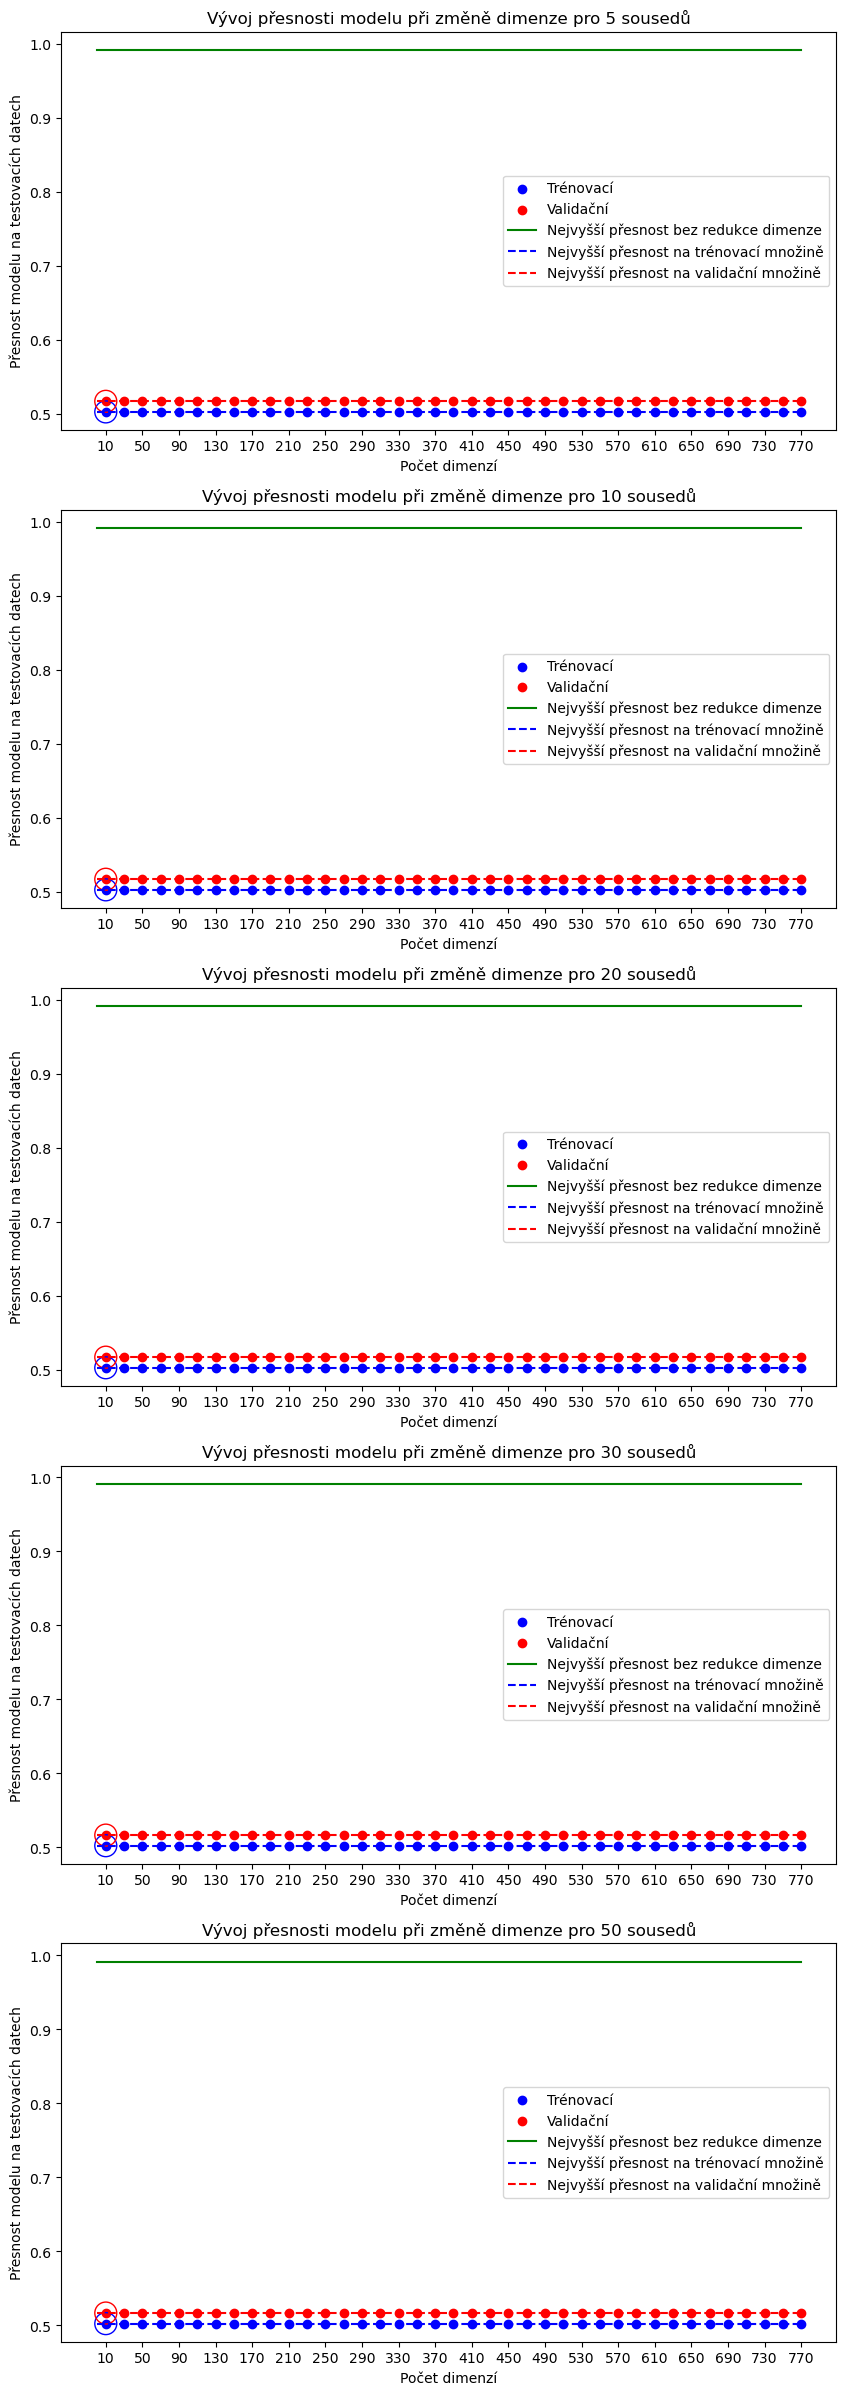

In [50]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30))
for iter, n_count in enumerate(NEIGHBOR_COUNTS): # přes různé počty sousedů
    for i, dim in enumerate(DIMENSIONS): # přes různé dimenze
        # LLE
        lle = LocallyLinearEmbedding(n_neighbors = n_count, n_components = dim)
        lle.fit(X_Train)

        # transformace dat do dim dimenzí
        X_Train_LLE = lle.transform(X_Train)
        X_Valid_LLE = lle.transform(X_Valid)
        
        # trénování
        clf_SVM_lin = SVC(C = C, kernel = 'linear')
        clf_SVM_lin.fit(X_Train_LLE, y_Train)

        # predikce chyby
        ACCs_train[i] = accuracy_score(y_Train, clf_SVM_lin.predict(X_Train_LLE)) # trénovací množina
        ACCs_valid[i] = accuracy_score(y_Valid, clf_SVM_lin.predict(X_Valid_LLE)) # validační množina
    
    plot_acc_development_LLE(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_svm_lin, n_count, iter, axs)

_Tento model tedy dosahuje nejlepšího výsledku bez redukce dimenzionality a to přesnosti na validační množině 99.2%_

A opět zkusíme i `SVM` model s **gaussovským jádrem**.

**Výsledky** po redukci dimenzionality jsou pro všechny hodnoty parametrů **totožné** jako bez redukce dimenzionality.

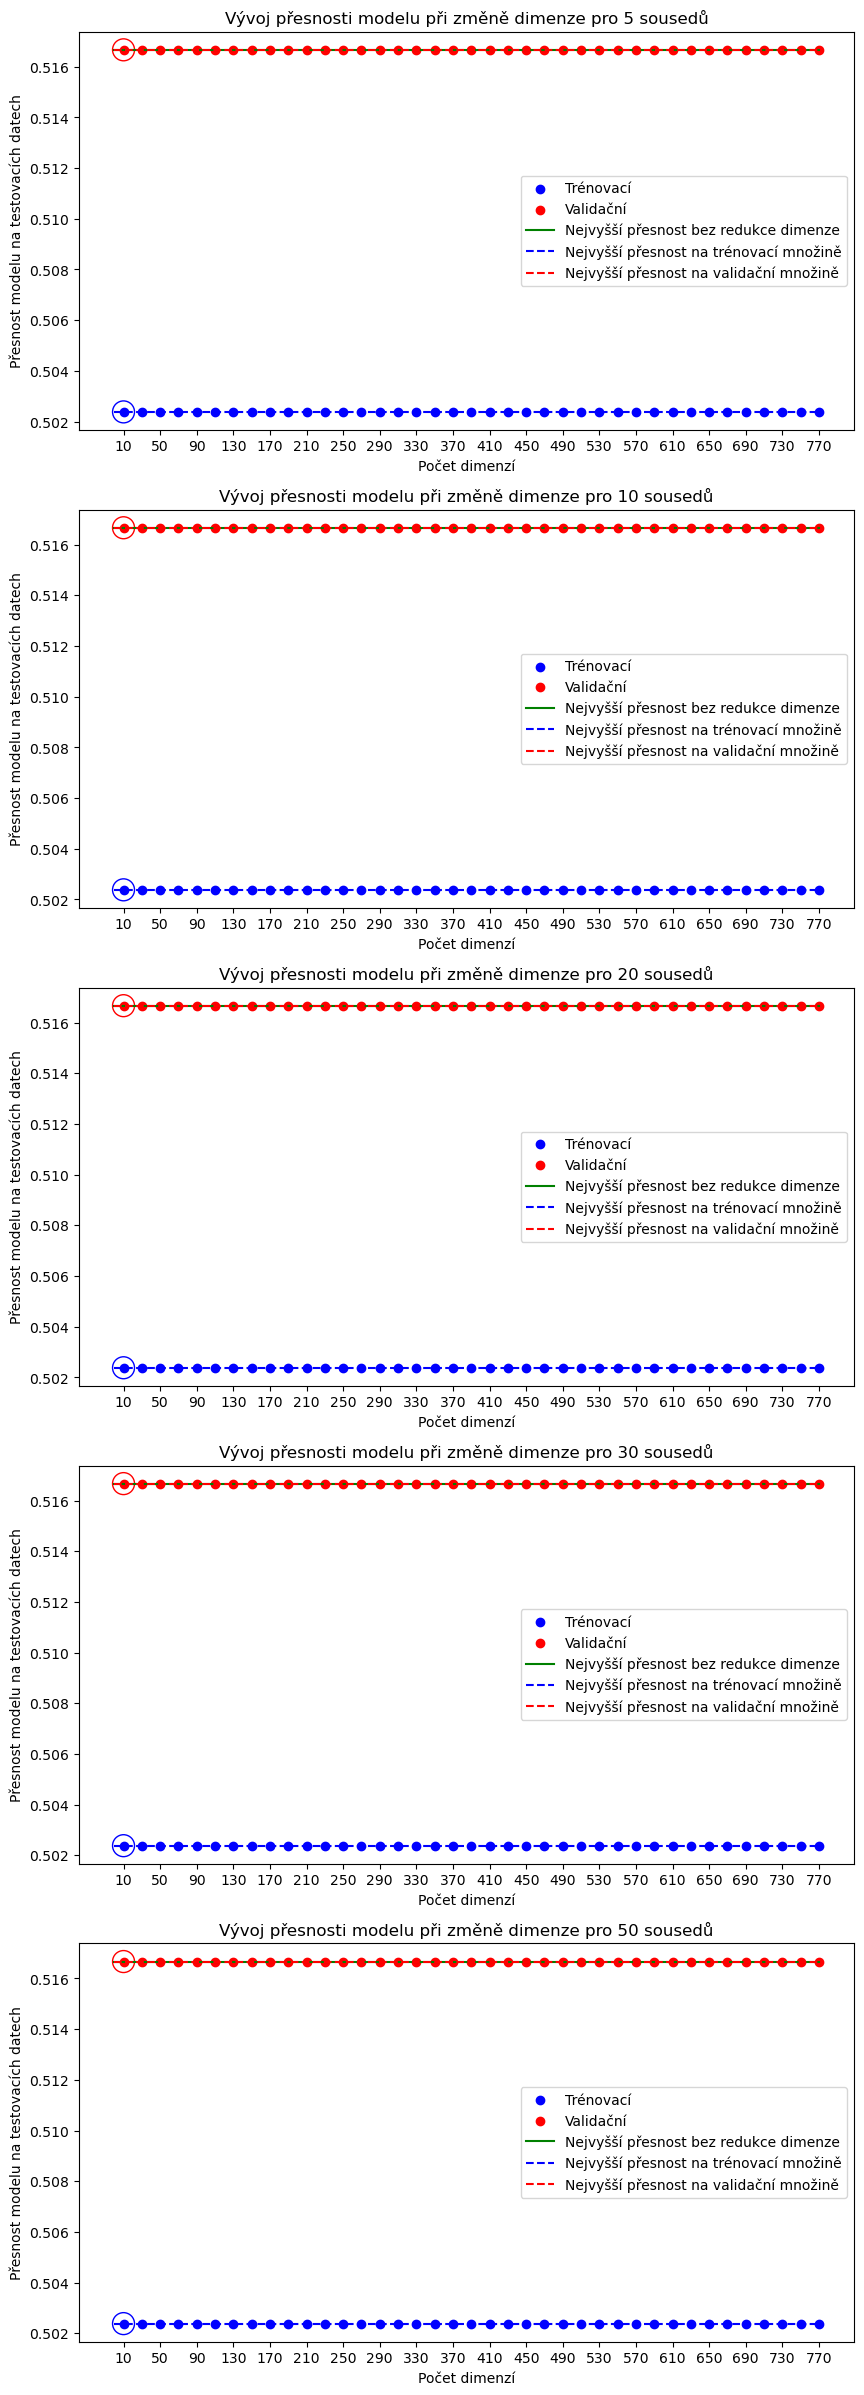

In [51]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30))
for iter, n_count in enumerate(NEIGHBOR_COUNTS): # přes různé počty sousedů
    for i, dim in enumerate(DIMENSIONS): # přes různé dimenze
        # LLE
        lle = LocallyLinearEmbedding(n_neighbors = n_count, n_components = dim)
        lle.fit(X_Train)

        # transformace dat do dim dimenzí
        X_Train_LLE = lle.transform(X_Train)
        X_Valid_LLE = lle.transform(X_Valid)
        
        # trénování
        clf_SVM_rbf = SVC(C = C, kernel = 'rbf', gamma = 'scale')
        clf_SVM_rbf.fit(X_Train_LLE, y_Train)

        # vyhodnocení
        ACCs_train[i] = accuracy_score(y_Train, clf_SVM_rbf.predict(X_Train_LLE)) # trénovací množina
        ACCs_valid[i] = accuracy_score(y_Valid, clf_SVM_rbf.predict(X_Valid_LLE)) # validační množina
    
    plot_acc_development_LLE(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_svm_rbf, n_count, iter, axs)

_Výsledek je opět v porovnání s ostatními modely neúměrně špatný a proto není kandidátem na finální model._

### naivní Bayesův klasifikátor

Nyní budeme trénovat `naivní Bayesův klasifikátor`.

Ani modelem `LLE` redukce dimenzionality **nezlepšila** výsledky. Opět se pohybují **~50%**.

Jediná dimenze a počet sousedů, kde se výsledky **přibližují** přesnosti bez redukce dimenzionality je při **dimenzi 10** a **počtem sousedů 50**.

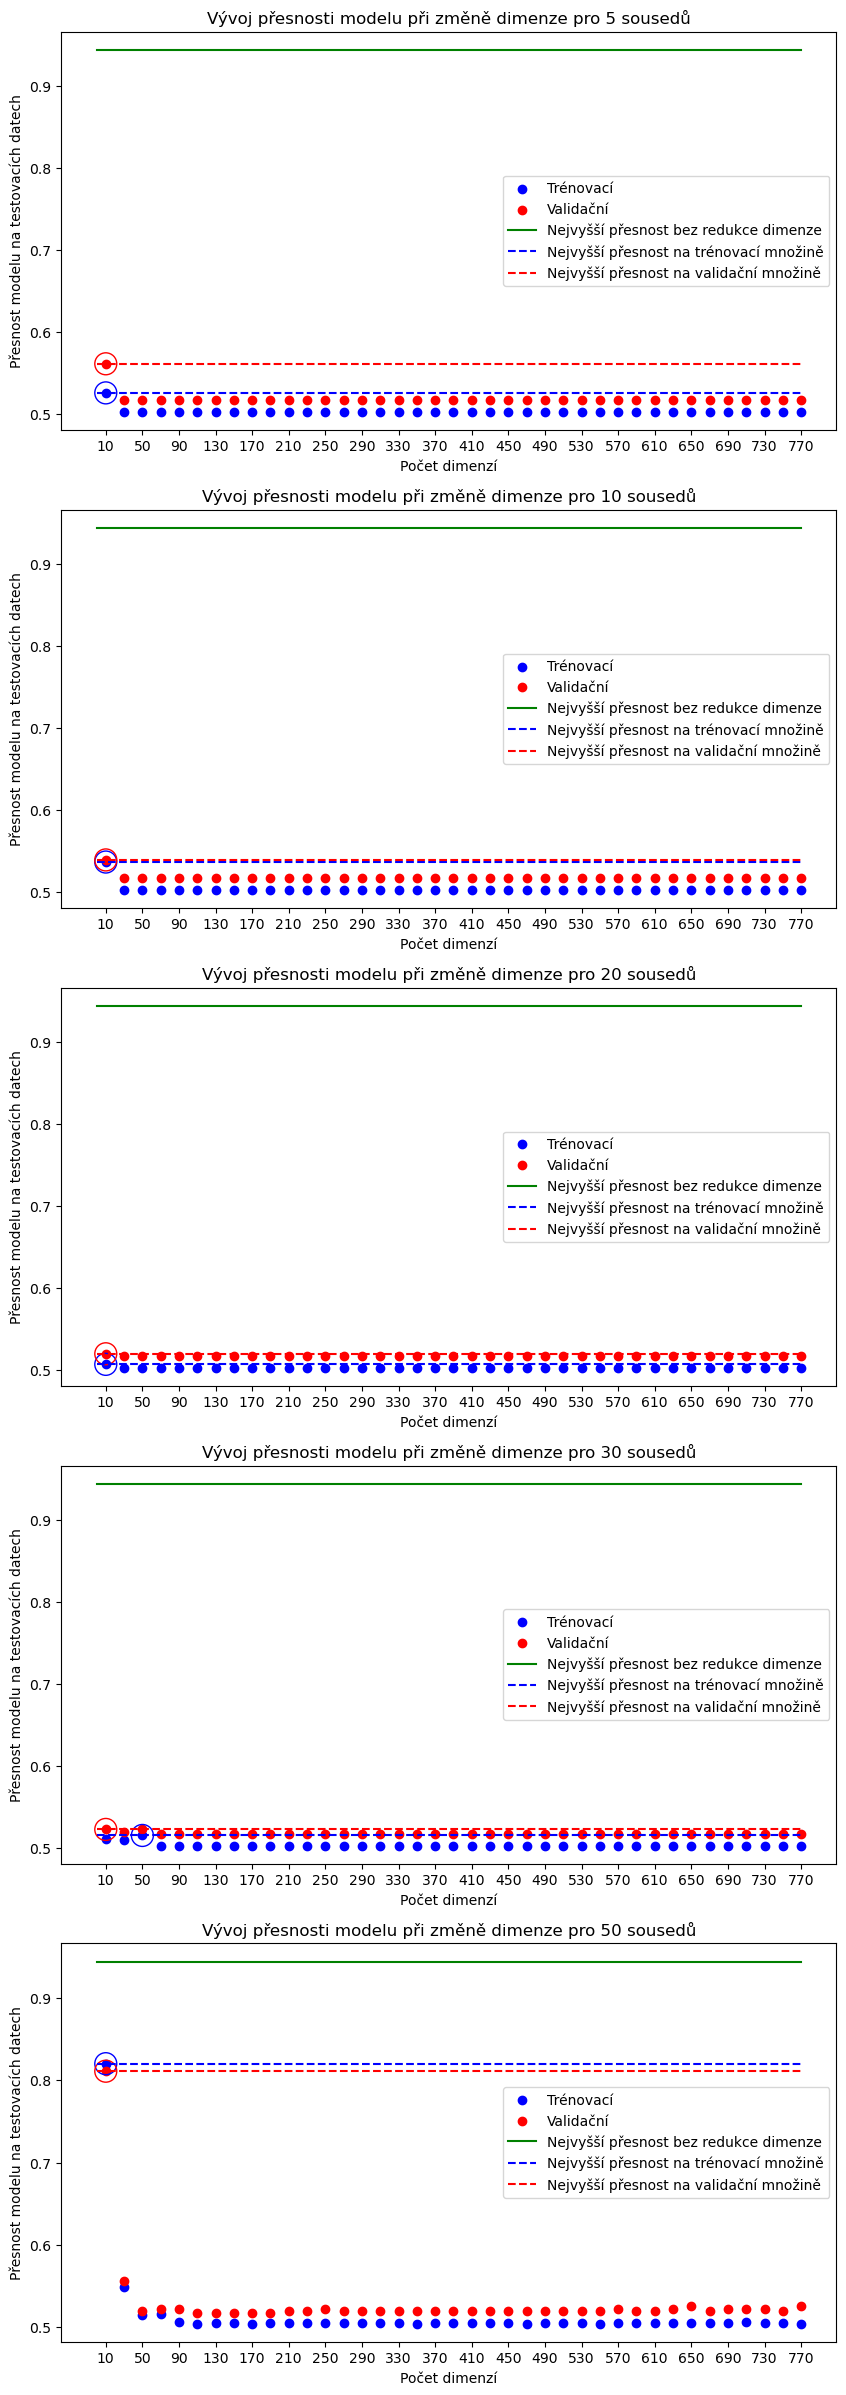

In [52]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30))
for iter, n_count in enumerate(NEIGHBOR_COUNTS): # přes různé počty sousedů
    for i, dim in enumerate(DIMENSIONS): # přes různé dimenze
        # LLE
        lle = LocallyLinearEmbedding(n_neighbors = n_count, n_components = dim)
        lle.fit(X_Train)

        # transformace dat do dim dimenzí
        X_Train_LLE = lle.transform(X_Train)
        X_Valid_LLE = lle.transform(X_Valid)

        # transformace datasetu na kladná čísla
        X_Train_LLE -= np.min(X_Train_LLE)
        X_Valid_LLE -= np.min(X_Valid_LLE)
        
        # trénování
        clf_multi = MultinomialNB()
        clf_multi.fit(X_Train_LLE, y_Train)

        # vyhodnocení
        ACCs_train[i] = accuracy_score(y_Train, clf_multi.predict(X_Train_LLE)) # trénovací množina
        ACCs_valid[i] = accuracy_score(y_Valid, clf_multi.predict(X_Valid_LLE)) # validační množina
    
    plot_acc_development_LLE(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_multi, n_count, iter, axs)

_Model opět dosahuje nejlepších výsledků bez redukce dimenzionality._

### LDA

Nyní zkusíme trénovat model `LDA`.

Redukce dimenzionality opět u tohoto modelu **výrazně zlepšila** predikce.

U všech hodnot parametru počtu sousedů pozorujeme **podobný trend** vývoje **přesnosti** na validační i trénovací množině.

Obě přesnosti se **zvyšováním počtu dimenzí rostou** a to až k téměř **~100%**.

DIMENZE, PŘESNOST
5 sousedů: 690, 0.994
10 sousedů: 490, 0.997
20 sousedů: 210, 0.997
30 sousedů: 130, 0.997
50 sousedů: 30, 0.997


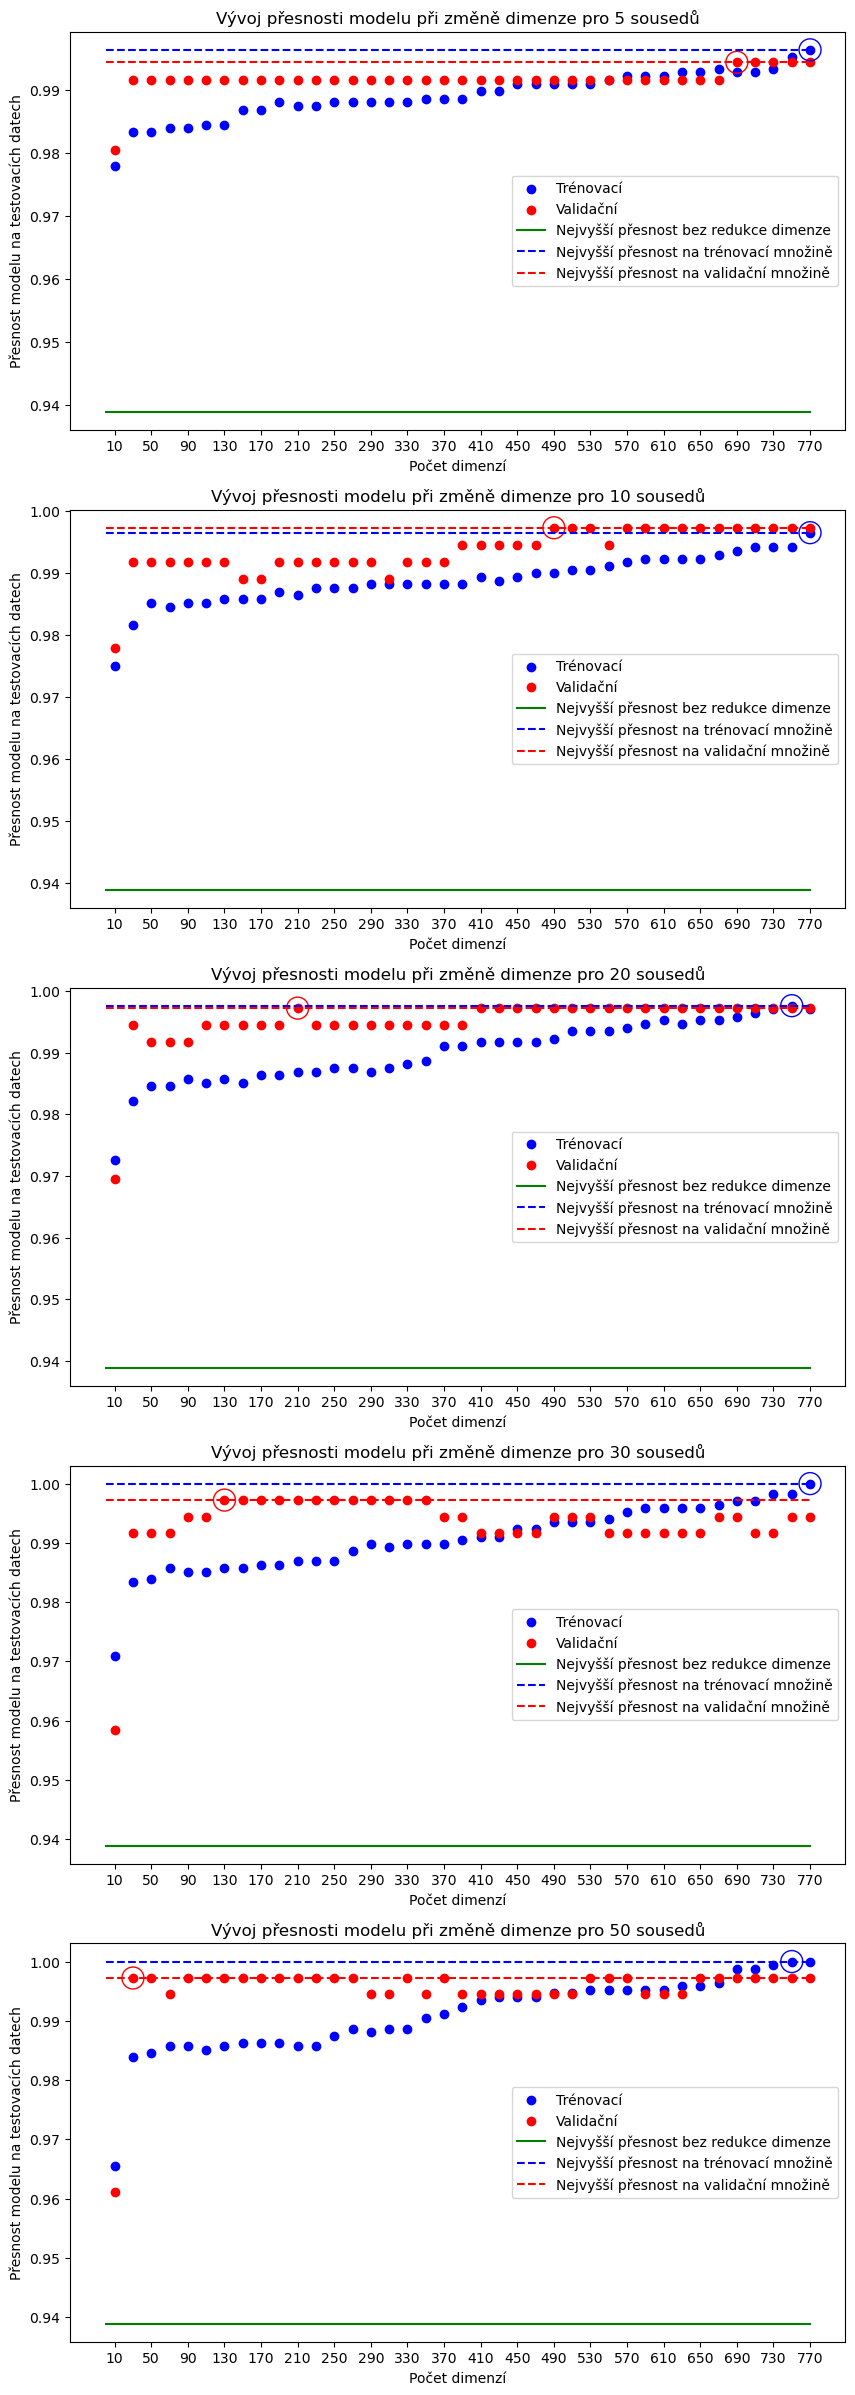

In [53]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30))
for iter, n_count in enumerate(NEIGHBOR_COUNTS): # přes různé počty sousedů
    for i, dim in enumerate(DIMENSIONS): # přes různé dimenze
        # LLE
        lle = LocallyLinearEmbedding(n_neighbors = n_count, n_components = dim)
        lle.fit(X_Train)

        # transformace dat do dim dimenzí
        X_Train_LLE = lle.transform(X_Train)
        X_Valid_LLE = lle.transform(X_Valid)

        # trénování
        clf_LDA = LinearDiscriminantAnalysis()
        clf_LDA.fit(X_Train_LLE, y_Train)

        # vyhodnocení
        ACCs_train[i] = accuracy_score(y_Train, clf_LDA.predict(X_Train_LLE)) # trénovací množina
        ACCs_valid[i] = accuracy_score(y_Valid, clf_LDA.predict(X_Valid_LLE)) # validační množina

    max_n_acc.append((DIMENSIONS[np.argmax(ACCs_valid)], np.max(ACCs_valid))) # uložení nejlepšího výsledku pro daný počet sousedů
    plot_acc_development_LLE(ACCs_train, ACCs_valid, DIMENSIONS, acc_valid_lda, n_count, iter, axs)

print_best_dims_n(max_n_acc, NEIGHBOR_COUNTS)

_Nejlepších výsledků dosahuje model při dimenzi 740 a počty sousedů 10 (s přesností), 20 (s přesností) a 50 (s přesností)._

## Finální model

_Z experimentů se jako nejpřesnější modely osvědčili následující:_

__`SVM` model s lineárním jádrem bez redukce dimenzionality__

In [54]:
clf_SVM_lin = SVC(C = C, kernel = 'linear')
clf_SVM_lin.fit(X_Train, y_Train)

SVC(C=0.0006265664160401002, kernel='linear')

In [55]:
pred_test_svm_lin = clf_SVM_lin.predict(X_Test)
print(f"Přesnost modelu na testovací množině: {accuracy_score(y_Test, pred_test_svm_lin):.3f}\n")

Přesnost modelu na testovací množině: 0.981



__`SVM` model s lineárním jádrem s redukcí dimenzionality pomocí PCA a 40 komponenty.__

In [56]:
# PCA
pca = PCA(n_components = 40)
pca.fit(X_Train)
X_Train_PCA = pca.transform(X_Train)
X_Test_PCA = pca.transform(X_Test)

# trénování
clf_SVM_lin_PCA = SVC(C = C, kernel = 'linear')
clf_SVM_lin_PCA.fit(X_Train_PCA, y_Train)

SVC(C=0.0006265664160401002, kernel='linear')

In [57]:
pred_test_svm_lin_PCA = clf_SVM_lin_PCA.predict(X_Test_PCA)
print(f"Přesnost modelu na testovací množině: {accuracy_score(y_Test, pred_test_svm_lin_PCA):.3f}\n")

Přesnost modelu na testovací množině: 0.992



__`Naivní Bayesova klasifikace` bez redukce dimenzionality.__

In [58]:
# trénování
clf_multi = MultinomialNB()
clf_multi.fit(X_Train, y_Train)

MultinomialNB()

In [59]:
pred_test_multi = clf_multi.predict(X_Test)
print(f"Odhad přesnosti modelu na testovací množině: {accuracy_score(y_Test, pred_test_multi):.3f}")

Odhad přesnosti modelu na testovací množině: 0.967


__`Lineární diskriminační analýza` s redukcí dimenzionality pomocí PCA a 180 komponenty.__

In [60]:
# PCA
pca = PCA(n_components = 180)
pca.fit(X_Train)
X_Train_PCA = pca.transform(X_Train) 
X_Test_PCA = pca.transform(X_Test)

# trénování
clf_LDA_PCA = LinearDiscriminantAnalysis()
clf_LDA_PCA.fit(X_Train_PCA, y_Train)

LinearDiscriminantAnalysis()

In [61]:
pred_test_LDA_PCA = clf_LDA_PCA.predict(X_Test_PCA)
print(f"Odhad přesnosti modelu na testovací množině: {accuracy_score(y_Test, pred_test_LDA_PCA):.3f}")

Odhad přesnosti modelu na testovací množině: 0.986


__`Lineární diskriminační analýza` s redukcí dimenzionality pomocí LLE na 770 dimenzí a 10, 20 a 50 komponenty.__

In [62]:
NEIGHBOR_COUNTS = [10, 20, 50]
dim = 770
for iter, n_count in enumerate(NEIGHBOR_COUNTS): # přes různé počty sousedů
    # LLE
    lle = LocallyLinearEmbedding(n_neighbors = n_count, n_components = dim)
    lle.fit(X_Train)

    # transformace dat do dim dimenzí
    X_Train_LLE = lle.transform(X_Train)
    X_Test_LLE = lle.transform(X_Test)

    # trénování
    clf_LDA_LLE = LinearDiscriminantAnalysis()
    clf_LDA_LLE.fit(X_Train_LLE, y_Train)

    # vyhodnocení
    pred_test_LDA_LLE = clf_LDA_LLE.predict(X_Test_LLE)
    print(f"Odhad přesnosti modelu na testovací množině pro {n_count} sousedů: {accuracy_score(y_Test, pred_test_LDA_LLE):.3f}")

Odhad přesnosti modelu na testovací množině pro 10 sousedů: 0.997
Odhad přesnosti modelu na testovací množině pro 20 sousedů: 0.997
Odhad přesnosti modelu na testovací množině pro 50 sousedů: 1.000


Jasně **nejpřesnějším** modelem na testovací množině je **`LDA` s redukcí dimenzionality na 770 komponent a s 50 sousedy**.

In [63]:
# LLE
lle = LocallyLinearEmbedding(n_neighbors = 50, n_components = 770)
lle.fit(X_Train)

# transformace dat do dim dimenzí
X_Train_LLE = lle.transform(X_Train)
X_Test_LLE = lle.transform(X_Test)

# trénování
final_model = LinearDiscriminantAnalysis()
final_model.fit(X_Train_LLE, y_Train)

LinearDiscriminantAnalysis()

### Odhad přesnosti na nových datech

Na testovacích datech byla **úspěšnost** modelu **100%**.

In [64]:
# predikce chyby
pred_test = final_model.predict(X_Test_LLE)
print(f"Odhad přesnosti: {int(accuracy_score(y_Test, pred_test) * 100)}%")

Odhad přesnosti: 100%


## Vyhodnocení dat

In [65]:
df_eval = pd.read_csv("evaluate.csv")
result = pd.DataFrame()

result["ID"] = df_eval["ID"]
result["label"] = final_model.predict(lle.transform(df_eval.drop("ID", axis=1))) # predikce

result.to_csv("results.csv") # uložení výsledku do souboru